# Importing required libraries

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from tqdm import tqdm_notebook
import warnings
import numpy as np
import statsmodels as sm

warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (25,5)

# Problem 1

The data for this project (Problem1_DataSet.csv) represents 7 years of monthly data on airline
miles flown in the United Kingdom. You are tasked with the goal of developing a forecasting model
that can accurately predict the trend for future years. To achieve the final goal, answer each of
the questions below.

In [81]:
df = pd.read_csv('Problem1_DataSet.csv', index_col = 'Month')
df

,"Miles, in Millions"
Month,
Jan-1964,7.269
Feb-1964,6.775
Mar-1964,7.819
Apr-1964,8.371
May-1964,9.069
...,...
Aug-1970,14.057
Sep-1970,16.234
Oct-1970,12.389


## Part 1

Create a time series of the plot of the data provided. (5 pts)

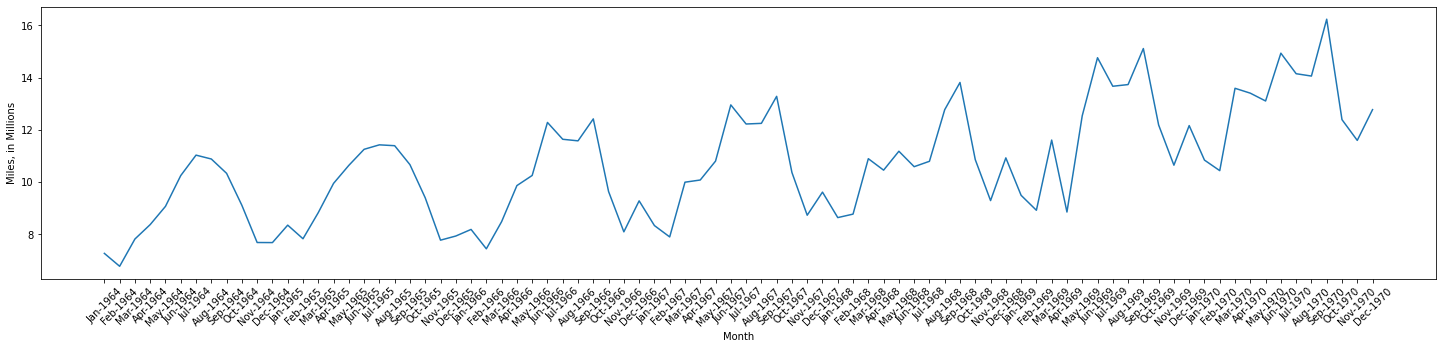

In [82]:
plt.xlabel('Month')
plt.ylabel('Miles, in Millions')
plt.xticks(rotation = 45)
plt.plot(df)
plt.show()

## Part 2

Plot the autocorrelation function (ACF). From the ACF, what is the seasonal period?
(5 pts)

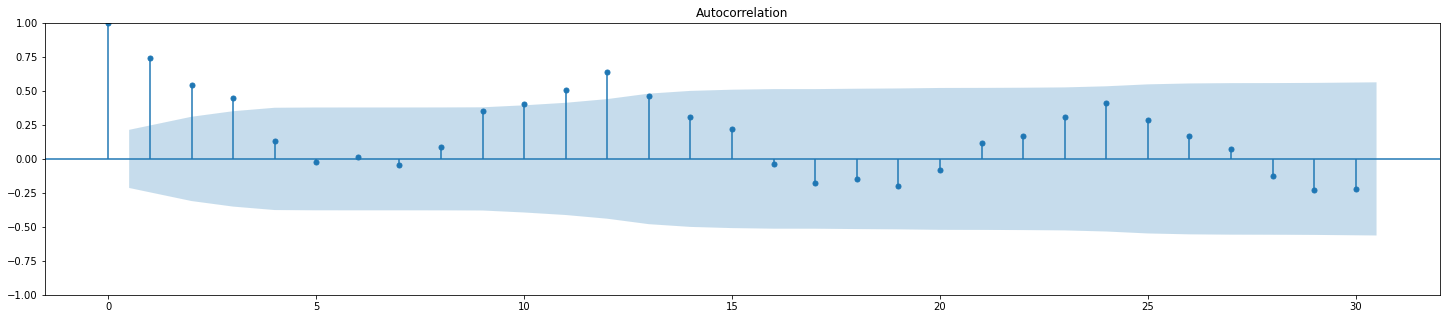

In [83]:
plot_acf(df['Miles, in Millions'], lags = 30);

The seasonal period is about 1 year.

## Part 3

Compute a moving average for the data to determine the trend in the data and overlay on the
original time-series plot. What is a suitable choice for the moving average window length? (5
pts)

In [84]:
def sma(data, time_span):
    start_index = time_span-1
    periods = []
    new_data = []

    for i in range(start_index, len(data)):
        point = data.iloc[i-time_span+1:i+1, 0].mean()
        new_data.append(point)
        periods.append(data.index[i])

    return pd.DataFrame(data={'Miles, in Millions':new_data, 'Month':periods}).set_index('Month')

In [85]:
sma_df = sma(df, 12)
sma_df

,"Miles, in Millions"
Month,
Dec-1964,8.856000
Jan-1965,8.946083
Feb-1965,9.033917
Mar-1965,9.118083
Apr-1965,9.249500
...,...
Aug-1970,12.884000
Sep-1970,12.977667
Oct-1970,12.994667


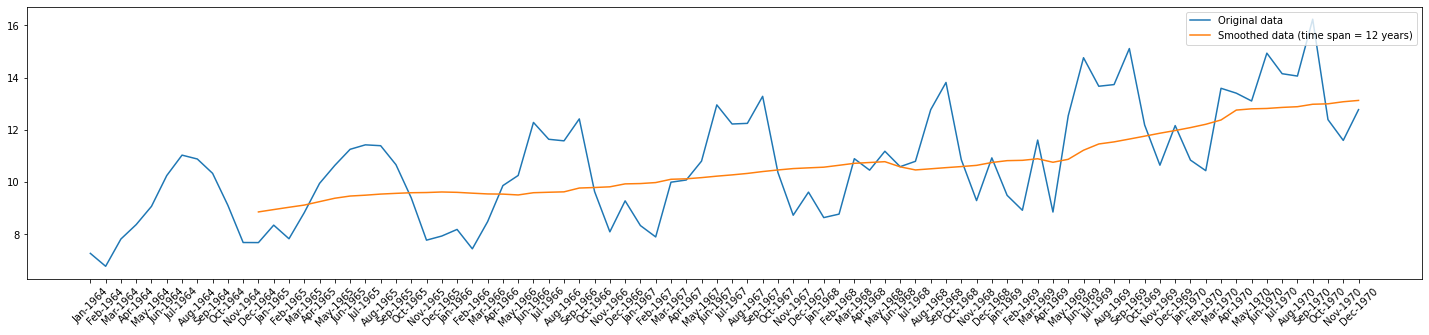

In [86]:
plt.plot(df.index, df['Miles, in Millions'])
plt.plot(sma_df.index, sma_df['Miles, in Millions'])
plt.legend(["Original data", "Smoothed data (time span = 12 years)"], loc ="upper right")
plt.xticks(rotation = 45)
plt.show()

As can be seen from the above figure, a suitable choice for the moving average window length would by 12
months.

## Part 4

Observing the moving average plot in Q3, is the trend line increasing or decreasing? (5 pts)

The trend is increasing. 

## Part 5

Compute the first difference of the data and plot the ACF and PACF for the differenced data.
What are the significant lags based on the ACF and PACF? (5 pts)

In [8]:
df_first_diff = df['Miles, in Millions'].diff()
df_first_diff

Month
Jan-1964      NaN
Feb-1964   -0.494
Mar-1964    1.044
Apr-1964    0.552
May-1964    0.698
            ...  
Aug-1970   -0.090
Sep-1970    2.177
Oct-1970   -3.845
Nov-1970   -0.795
Dec-1970    1.178
Name: Miles, in Millions, Length: 84, dtype: float64

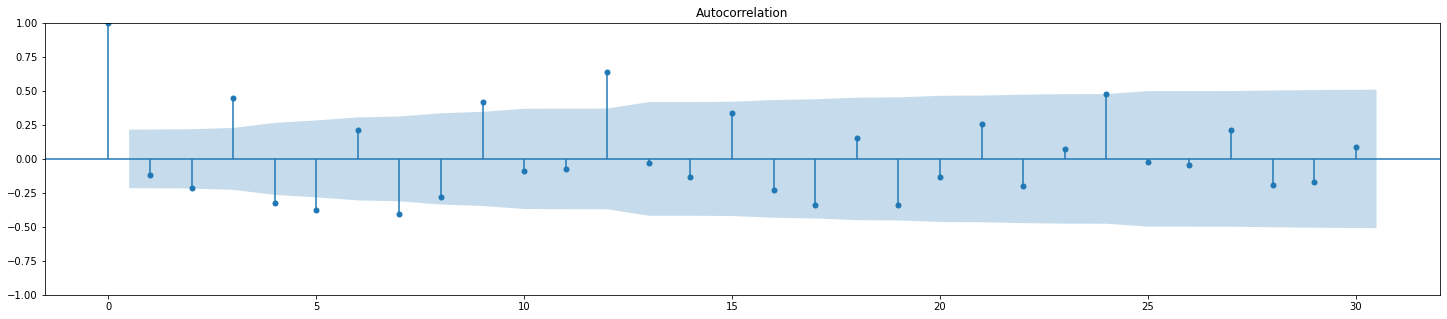

In [9]:
plot_acf(df_first_diff.dropna(), lags = 30);

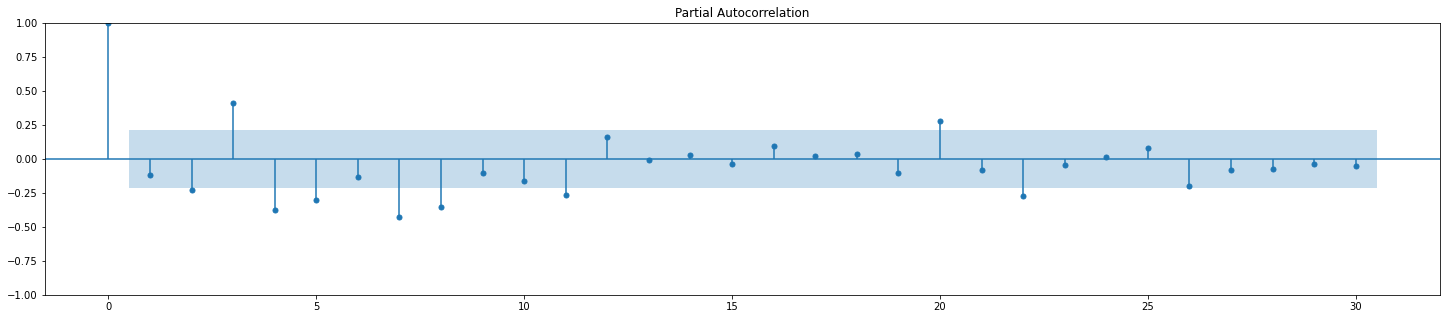

In [10]:
plot_pacf(df_first_diff.dropna(), lags = 30, method='ywm');

The significant lag based on the acf plot is 12 and based on the pacf plot is 3.

## Part 6

Using the output from Q5 above, perform a first seasonal difference with the seasonal period
you identified in Q2, and plot the ACF and PACF again. What are the significant lags based
on the ACF and PACF? (5 pts)

In [11]:
df_seasonal_diff = df['Miles, in Millions'] - df['Miles, in Millions'].shift(12)
df_seasonal_diff

Month
Jan-1964      NaN
Feb-1964      NaN
Mar-1964      NaN
Apr-1964      NaN
May-1964      NaN
            ...  
Aug-1970    0.326
Sep-1970    1.124
Oct-1970    0.204
Nov-1970    0.949
Dec-1970    0.611
Name: Miles, in Millions, Length: 84, dtype: float64

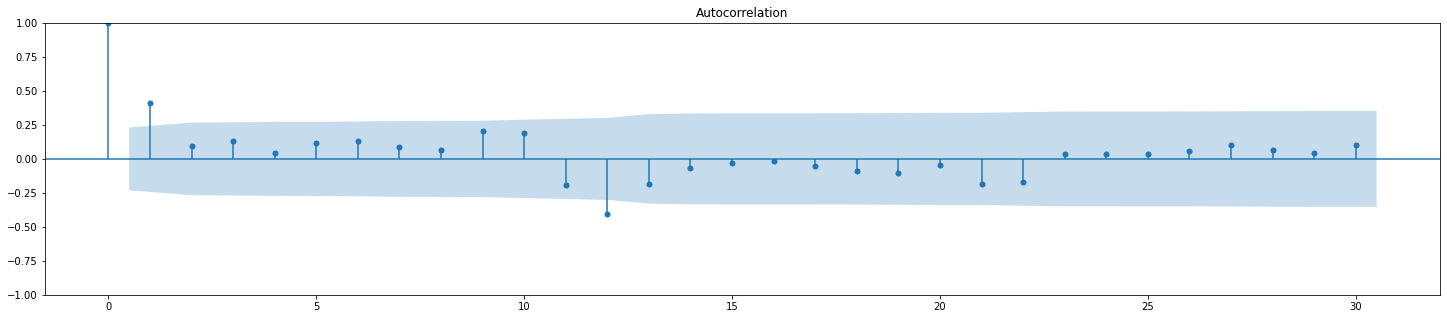

In [12]:
plot_acf(df_seasonal_diff.dropna(), lags = 30);

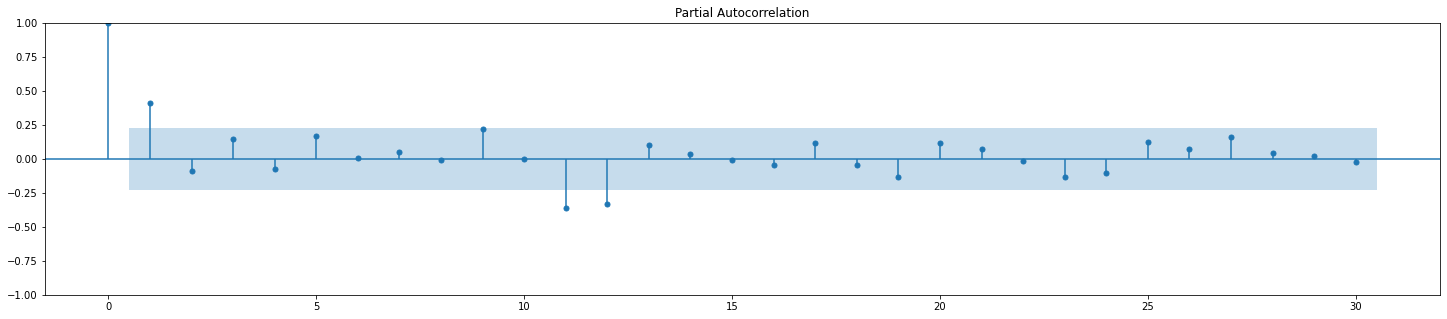

In [13]:
plot_pacf(df_seasonal_diff.dropna(), lags = 30, method='ywm');

## Part 7

Develop a suitable SARIMA model that can be applied on the time series. Use the first 6 years
of data only to develop the model. (20 pts)

a. To develop the model, vary the model parameters for the non-seasonal (p,d,q) and
seasonal components (P,D,Q) and calculate the output for each combination of
parameters.

b. Use an evaluation criteria such as AIC, BIC or sum squared error or mean squared
error to determine the best choice of parameters (p,d,q,P,D,Q). Note: AIC and BIC
are metrics that is readily output by the ARIMA model.

In [14]:
df_train = df.iloc[:72,:]
df_train

,"Miles, in Millions"
Month,
Jan-1964,7.269
Feb-1964,6.775
Mar-1964,7.819
Apr-1964,8.371
May-1964,9.069
...,...
Aug-1969,13.731
Sep-1969,15.110
Oct-1969,12.185


In [15]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [16]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [17]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, df_train['Miles, in Millions'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 2, 1)",12.000000
1,"(2, 3, 2, 2)",186.856747
2,"(0, 2, 2, 0)",188.008253
3,"(2, 3, 3, 2)",188.651208
4,"(1, 3, 2, 2)",188.989762
...,...,...
251,"(0, 0, 0, 0)",301.643168
252,"(0, 1, 0, 0)",303.410448
253,"(1, 0, 0, 0)",303.456770
254,"(2, 0, 0, 0)",304.357146


In [18]:
best_model = SARIMAX(df_train['Miles, in Millions'], order=(1, 1, 1), seasonal_order=(2, 1, 1, 12)).fit(dis=-1)
best_model.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23780D+00    |proj g|=  3.88390D-01

At iterate    5    f=  1.00744D+00    |proj g|=  3.73641D-02

At iterate   10    f=  9.93131D-01    |proj g|=  3.05237D-02

At iterate   15    f=  9.91912D-01    |proj g|=  4.36098D-03

At iterate   20    f=  9.91383D-01    |proj g|=  1.89215D-03

At iterate   25    f=  9.91253D-01    |proj g|=  1.46766D-03

At iterate   30    f=  9.91169D-01    |proj g|=  2.60758D-03

At iterate   35    f=  9.91137D-01    |proj g|=  4.71780D-04

At iterate   40    f=  9.91129D-01    |proj g|=  2.16290D-04

At iterate   45    f=  9.91127D-01    |proj g|=  7.62136D-04

At iterate   50    f=  9.91127D-01    |proj g|=  1.85242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 Miles, in Millions   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -71.361
Date:                            Wed, 26 Oct 2022   AIC                            154.722
Time:                                    21:18:28   BIC                            167.187
Sample:                                01-01-1964   HQIC                           159.588
                                     - 12-01-1969                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3679      0.211      1.741      0.082      -0.046       0.782
ma.L1         -0.9989      6.680     -0.150      0.881     -14.091      12.093
ar.S.L12      -1.3529      2.758     -0.490      0.624      -6.759       4.054
ar.S.L24      -0.4261      1.061     -0.401      0.688      -2.507       1.654
ma.S.L12       0.9833     10.369      0.095      0.924     -19.340      21.307
sigma2         0.5707      7.108      0.080      0.936     -13.361      14.502
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                21.43
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.63   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

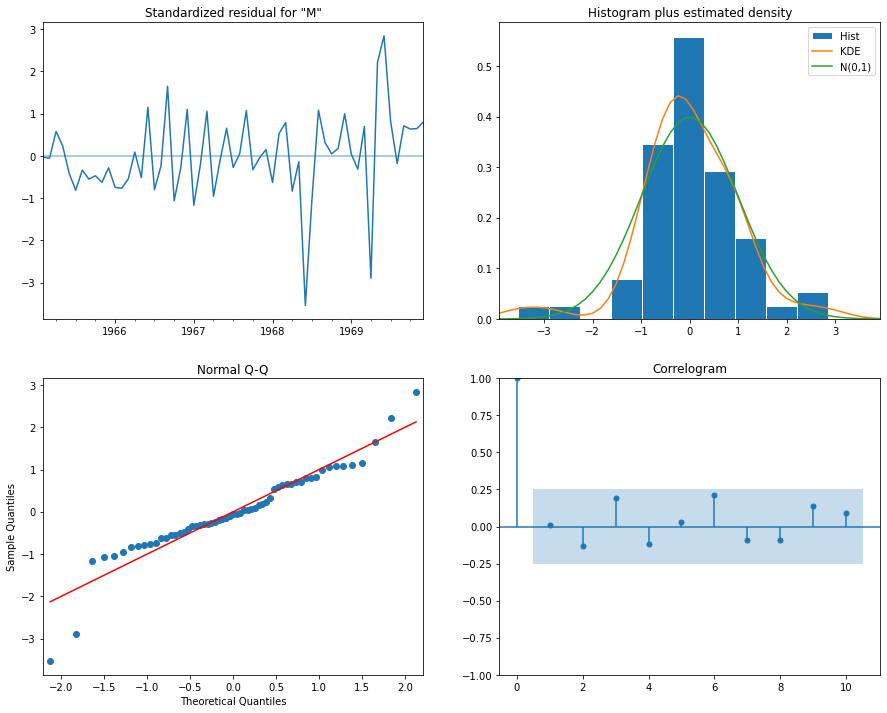

In [19]:
best_model.plot_diagnostics(figsize=(15,12));

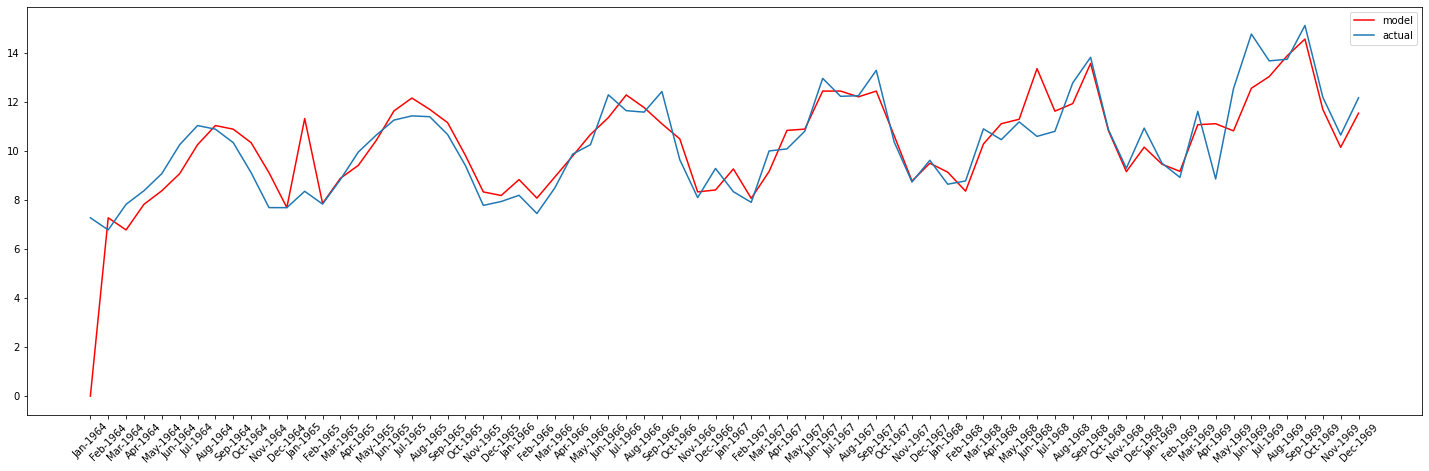

In [20]:
df_train['arima_model'] = best_model.fittedvalues
plt.figure(figsize=(25, 7.5))
plt.plot(df_train['arima_model'], color='r', label='model')
plt.plot(df_train['Miles, in Millions'], label='actual')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

## Part 8

Use the model parameters determined in Q7 above to forecast for the 7th year. Compare the
forecast with actual values. Comment on your observations. (10 pts)

In [21]:
forecast = best_model.forecast(steps = 12)
forecast = df_train['arima_model'].append(forecast)
forecast = forecast.to_frame().reset_index().iloc[:,1]
forecast

0      0.000000
1      7.268999
2      6.775000
3      7.819000
4      8.371000
        ...    
79    14.182875
80    15.372481
81    12.478162
82    10.908102
83    12.404746
Name: 0, Length: 84, dtype: float64

In [22]:
df_plot = df.reset_index()
df_plot

,Month,"Miles, in Millions"
0,Jan-1964,7.269
1,Feb-1964,6.775
2,Mar-1964,7.819
3,Apr-1964,8.371
4,May-1964,9.069
...,...,...
79,Aug-1970,14.057
80,Sep-1970,16.234
81,Oct-1970,12.389
82,Nov-1970,11.594


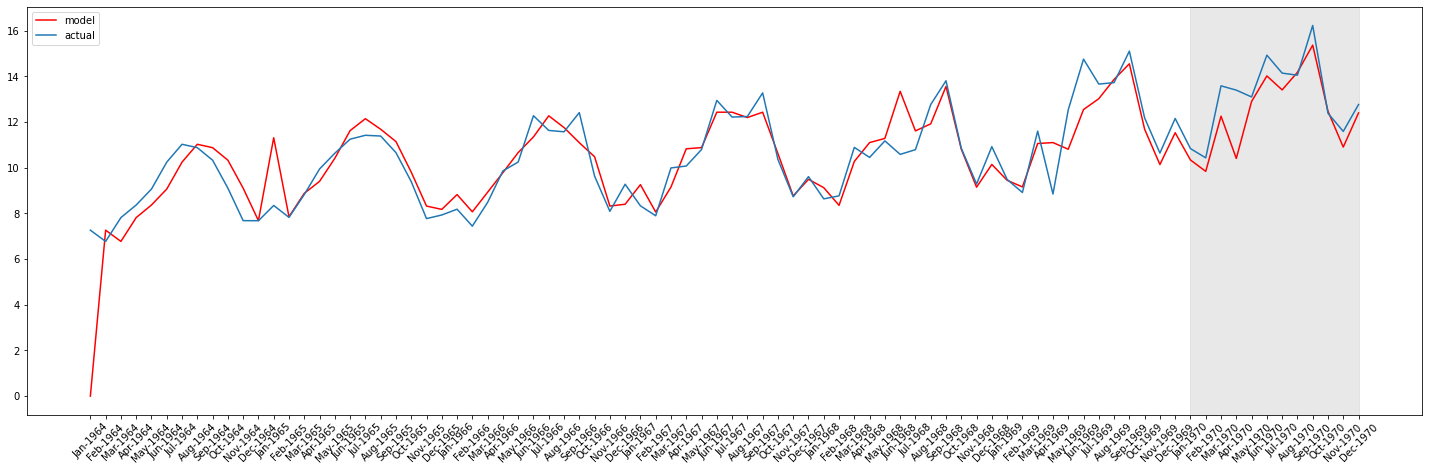

In [23]:
plt.figure(figsize=(25, 7.5))
plt.plot(forecast, color='r', label='model')
plt.plot(df['Miles, in Millions'], label='actual')
plt.axvspan(df.index[-12], df.index[-1], alpha=0.5, color='lightgrey')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

The forecasted values are in red inside the grey strip. They very closely capture the trend of the actual data for the most part except for about 2 months.

# Problem 2 


In this problem, you will develop a time-series model to analyze Wine consumption from the data
file “TotalWine.csv”.

In [24]:
df = pd.read_csv('TotalWine.csv', index_col = 'Time (Quarter)')
df

,TotalWine
Time (Quarter),
1,1.486
2,1.915
3,1.844
4,2.808
5,1.287
6,1.861
7,2.034
8,2.739
9,1.656


## Part a

Plot the time series for TotalWine. What is the seasonal period for this time-series? (1 pt)


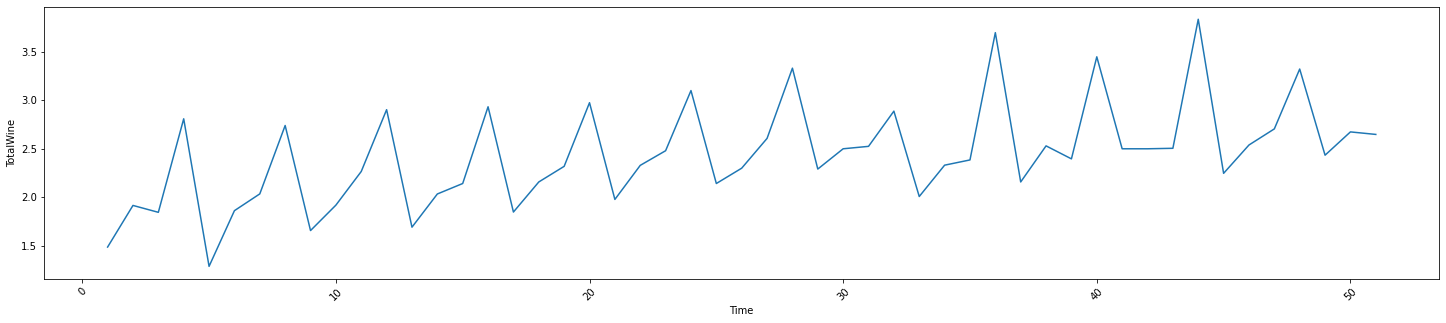

In [25]:
plt.xlabel('Time')
plt.ylabel('TotalWine')
plt.xticks(rotation = 45)
plt.plot(df)
plt.show()

The seasonal period is 4.

## Part b 

Apply seasonal differencing to the original time-series. Vary the difference lag from 1, 2, 4, 6.
Plot the result for each of these lags. Which of these differences is most suitable to remove
the seasonality? (2 pts)

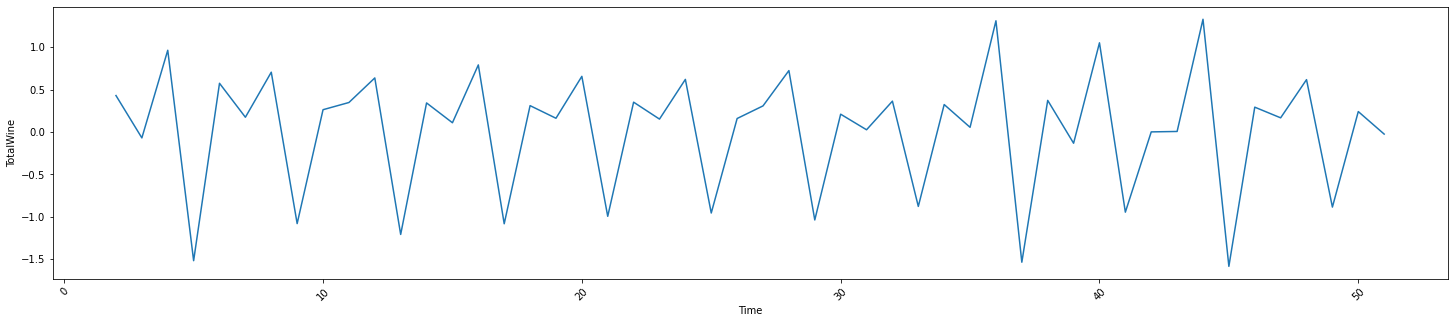

In [34]:
df_diff_1 = df['TotalWine'] - df['TotalWine'].shift(1)
plt.xlabel('Time')
plt.ylabel('TotalWine')
plt.xticks(rotation = 45)
plt.plot(df_diff_1)
plt.show()

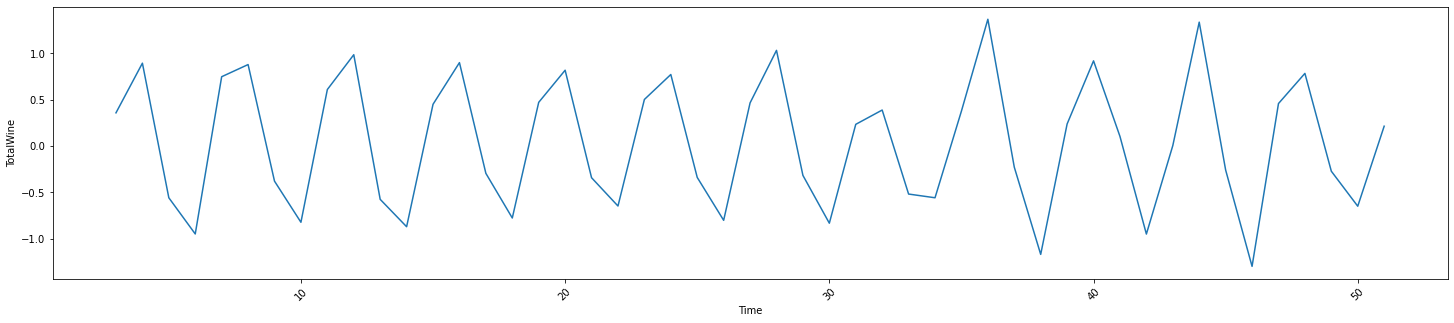

In [35]:
df_diff_2 = df['TotalWine'] - df['TotalWine'].shift(2)
plt.xlabel('Time')
plt.ylabel('TotalWine')
plt.xticks(rotation = 45)
plt.plot(df_diff_2)
plt.show()

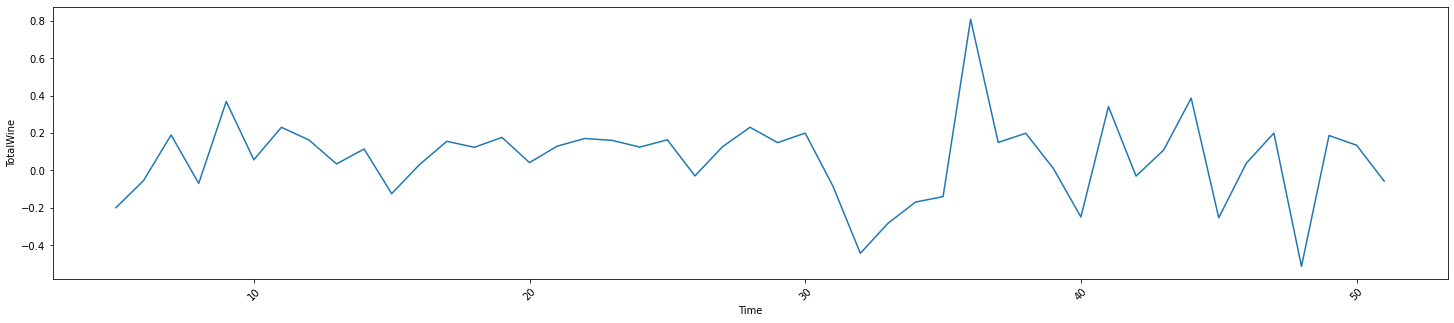

In [36]:
df_diff_4 = df['TotalWine'] - df['TotalWine'].shift(4)
plt.xlabel('Time')
plt.ylabel('TotalWine')
plt.xticks(rotation = 45)
plt.plot(df_diff_4)
plt.show()

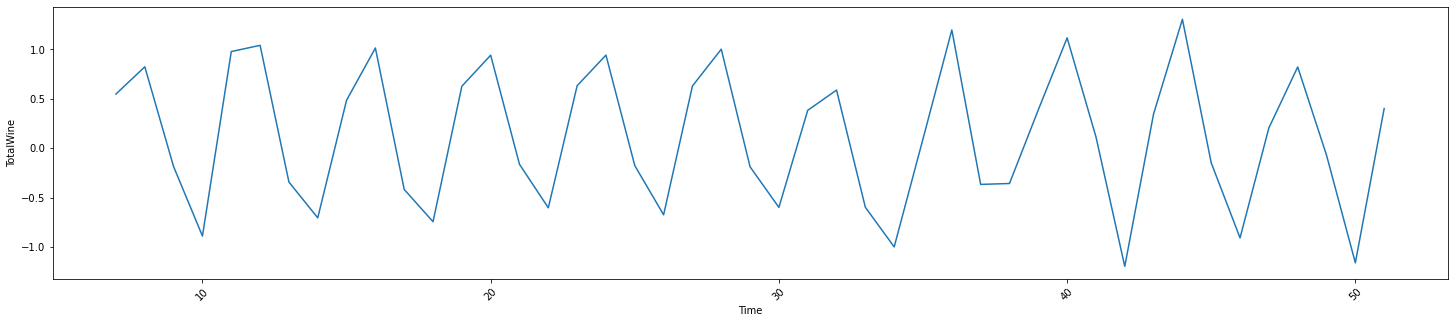

In [37]:
df_diff_6 = df['TotalWine'] - df['TotalWine'].shift(6)
plt.xlabel('Time')
plt.ylabel('TotalWine')
plt.xticks(rotation = 45)
plt.plot(df_diff_6)
plt.show()

A lag of 4 is the most suitable to remove seasonality.

## Part c

Compute and plot the Auto-correlation (ACF) function for the original time-series. What is the
seasonal period you estimate from the ACF? (1 pt)

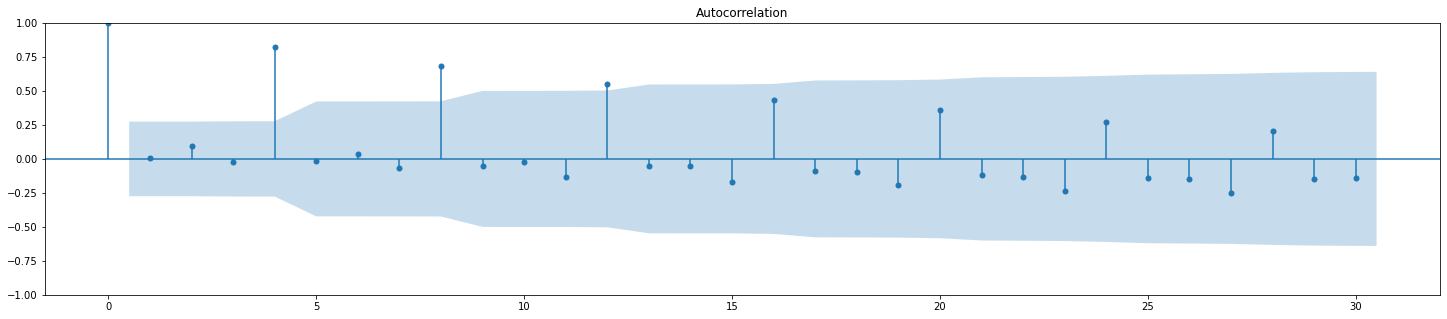

In [38]:
plot_acf(df, lags = 30);

The seasonal period is 4 quarters.

## Part d

Define an AR model using tsa.AR available in statsmodels.api. Determine the optimal order
using the “select_order” function. You will need to specify a maximum order p (recommend
p=10) to consider and a criterion for deciding which model order is "best". [e.g. You can use
AIC as the model selection criteria] (2 pts)

In [40]:
df_seasonal_diff = df['TotalWine'].diff(periods=4).dropna().reset_index(drop=True)

In [71]:
# AR model using tsa.AR available in statsmodels.api was unavailable

opt_order = sm.tsa.ar_model.AutoReg(df_seasonal_diff, lags=10).ar_lags
print('optimal lag = ', 5)

optimal lag =  5


## Part e

Now, evaluate an AR(p) model for the time-series generated after seasonal differencing (using
the best lag you found in part b above) (4 pts)

i. use the fit method specifying the optimal lag found above

ii. use the predict method to generate values starting at the optimal lag

iii. plot the predicted results and the corresponding seasonally differenced time-series

iv. Calculate the Mean Absolute Error (MAE) by comparing the predicted results with the
seasonally differenced data.

In [69]:
model = ARIMA(df_seasonal_diff, order=(5,0,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              TotalWine   No. Observations:                   47
Model:                 ARIMA(5, 0, 0)   Log Likelihood                  16.795
Date:                Wed, 26 Oct 2022   AIC                            -19.590
Time:                        22:15:05   BIC                             -6.639
Sample:                             0   HQIC                           -14.717
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0722      0.021      3.389      0.001       0.030       0.114
ar.L1          0.0824      0.144      0.571      0.568      -0.200       0.365
ar.L2          0.0455      0.161      0.282      0.778      -0.270       0.361
ar.L3          0.0521      0.098      0.533      0.594      -0.139       0.244
ar.L4         -0.6723      0.119     -5.645      0.000      -0.906      -0.439
ar.L5          0.1421      0.145      0.983      0.325      -0.141       0.425
sigma2         0.0271      0.006      4.187      0.000       0.014       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.97   Prob(JB):                         0.71
Heteroskedasticity (H):               3.02   Skew:                            -0.09
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

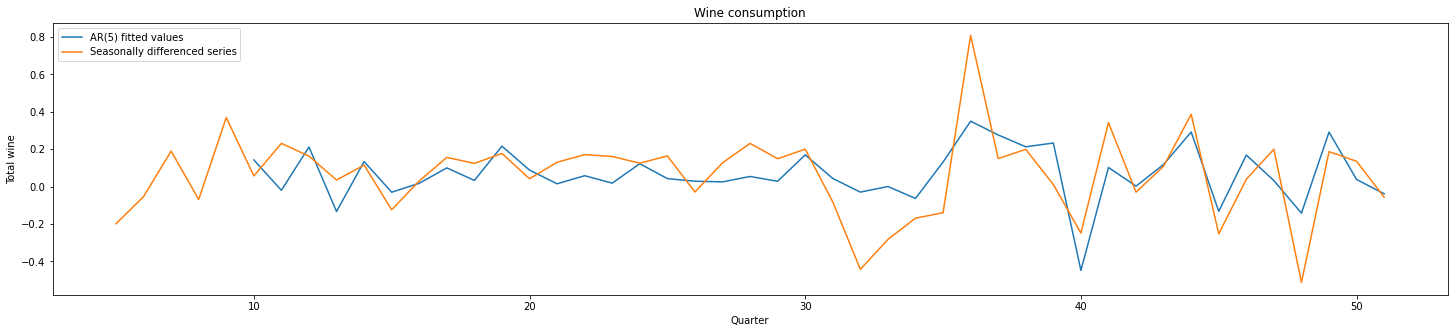

In [78]:
model_predict = model_fit.predict(start=5,end=len(df_seasonal_diff) - 1, typ='levels').rename("Predictions")
plt.plot(df.iloc[4+5:].index, model_predict, label='AR(5) fitted values')
plt.plot(df.iloc[4:].index, df_seasonal_diff, label='Seasonally differenced series')
plt.xlabel('Quarter')
plt.ylabel('Total wine')
plt.title('Wine consumption')
plt.legend(loc="upper left")
plt.show()

In [79]:
mae = (model_predict - df_seasonal_diff.loc[5:]).abs().sum() / len(model_predict)
mae

0.13094130994233436

# References

1. https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b